# Part 2 - Model building and selection

This notebook is part 2 of the capstone project from the [IBM AI Enterprise Workflow specialization](https://www.coursera.org/specializations/ibm-ai-workflow). The main goal here is to compare different models to predict revenue, given the [data](https://github.com/aavail/ai-workflow-capstone), and select one to be put into production.

Author: Rafael da Ponte Barbosa

In [1]:
import pandas as pd
import numpy as np
import os
import datetime

import matplotlib.pyplot as plt
from fbprophet import Prophet

from sklearn.metrics import mean_squared_error

plt.style.use('seaborn')

from application.utils.ingestion import fetch_data,fetch_ts
from application.utils.processing import convert_to_ts, engineer_features

from application.utils.plot import ts_plot, ts_plot_pred

%load_ext autoreload
%autoreload 2

In [2]:
data_dir = os.path.join("data","cs-train")
ts_data = fetch_ts(data_dir)

... loading ts data from files


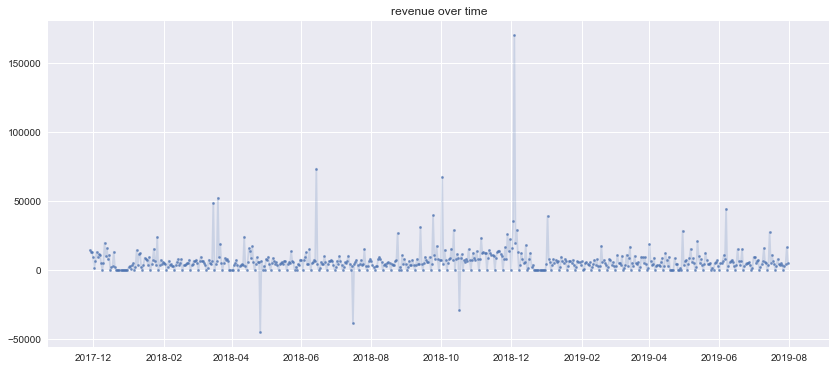

In [3]:
ts_plot(ts_data['all'].date.values, ts_data['all'].revenue.values,figx=14,figy=6, title="revenue over time")

## Baseline

We'll employ a simple moving average as the baseline for forecasting, and we'll use MSE as the optimization metric. Note that is is closely related to the business problem: if we want to predict revenue over time, a low MSE indicates good accuracy. To keep things simple, we'll compare model performances for all data points and for the 3 top countries (w.r.t revenue): UK, EIRE and Germany. For all, we use a simple train/test split over time, where the last 30 data points are kept as test, while the remaining ones are used for training. In the case of moving average, we'll do "out-of-sample" prediction, where predicted values are used to infer new ones.

We compare here three time windows: 7, 14 and 28; we conclude, by observing the errors, that the latter performs the best.

In [4]:
windows = [7,14,28]
keys = ['all', 'united_kingdom', 'eire', 'germany']
results = []

for window in windows:
    print("Using window {}".format(window))
    mse = []
    
    for key in keys:
        df = ts_data[key]
        df_train = ts_data[key][:-30]
        df_test = ts_data[key][-30:].copy()

        y_pred = df_train.revenue.values

        for date in df_test.date:
            y_pred = np.append(y_pred, np.mean(y_pred[-window:]))

        df_test['pred'] = y_pred[-30:]
        
        mse.append(mean_squared_error(df_test.revenue, df_test.pred))

    results.append(np.mean(mse))
    print("Average MSE: {}".format(results[-1]))
    

Using window 7
Average MSE: 16595181.022210326
Using window 14
Average MSE: 15829939.271474602
Using window 28
Average MSE: 14897365.436453233


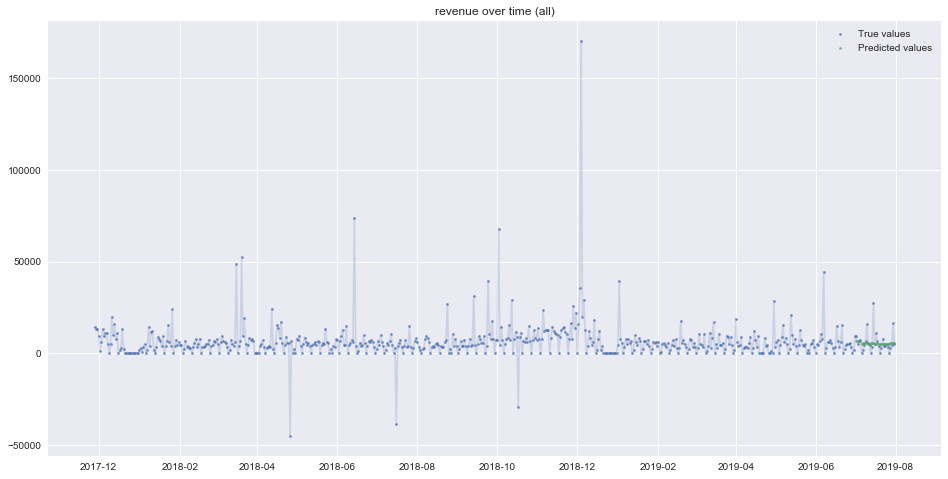

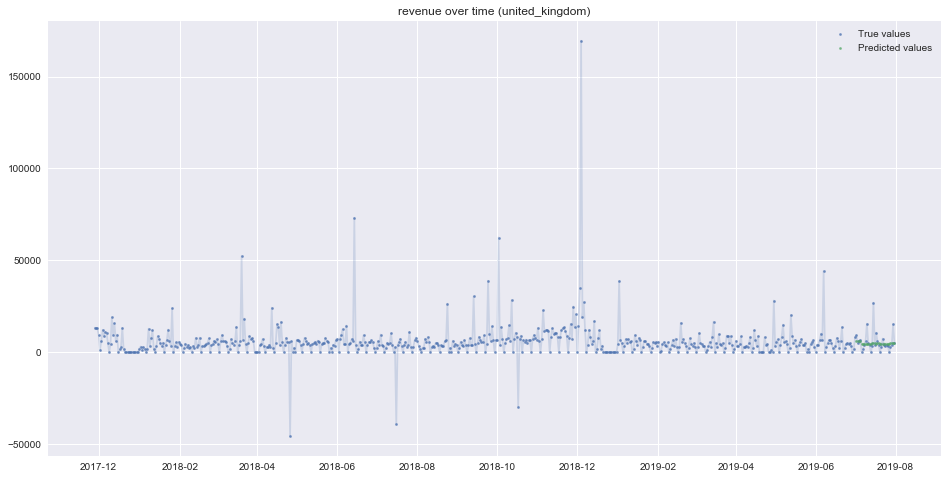

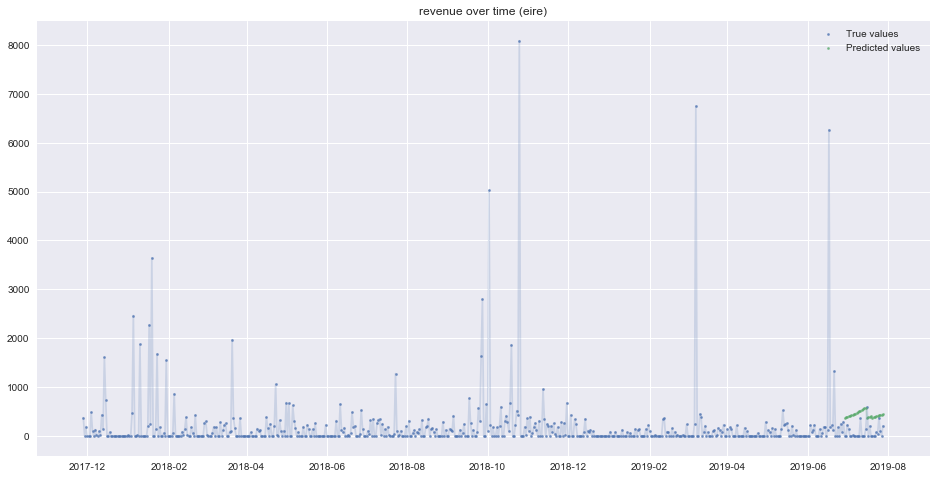

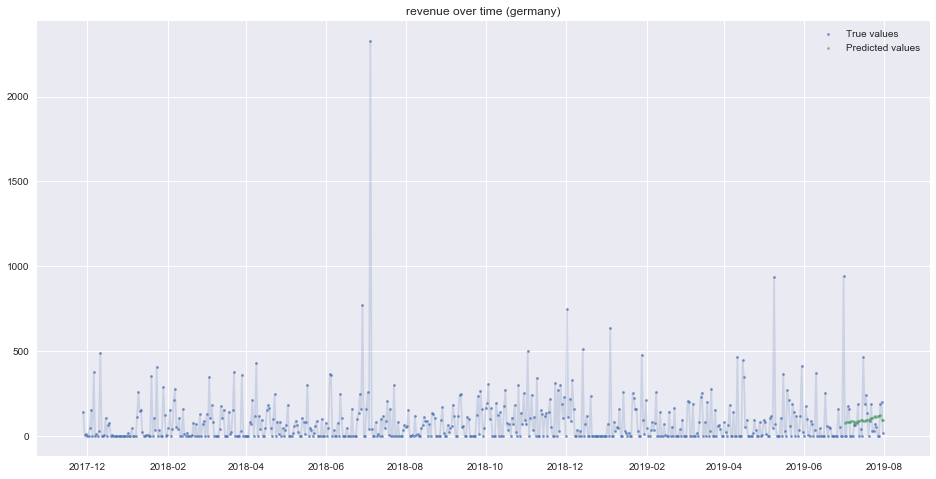

In [5]:
window = 28
keys = ['all', 'united_kingdom', 'eire', 'germany']
mse_baseline = {}
y_pred = {}

for key in keys:
    df = ts_data[key].copy(deep=True)
    df_train = df[:-30]
    df_test = df[-30:].copy()
    
    y_pred[key] = df_train.revenue.values

    for date in df_test.date:
        y_pred[key] = np.append(y_pred[key], np.mean(y_pred[key][-window:]))

    df_test['pred'] = y_pred[key][-30:]
    
    mse_baseline[key] = mean_squared_error(df_test.revenue, df_test.pred)
    
    ts_plot_pred(df.date.values, df.revenue.values,\
         df[-30:].date.values, y_pred[key][-30:], figx=16,figy=8, title="revenue over time ({})".format(key))

## Prophet

We'll now try [FB Prophet](https://research.fb.com/prophet-forecasting-at-scale/), a time series forecasting tool open sourced by Facebook Research.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


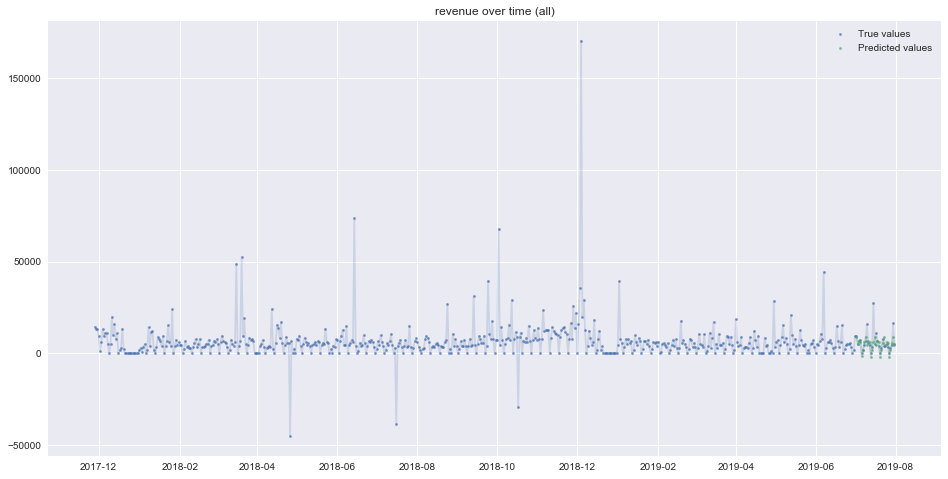

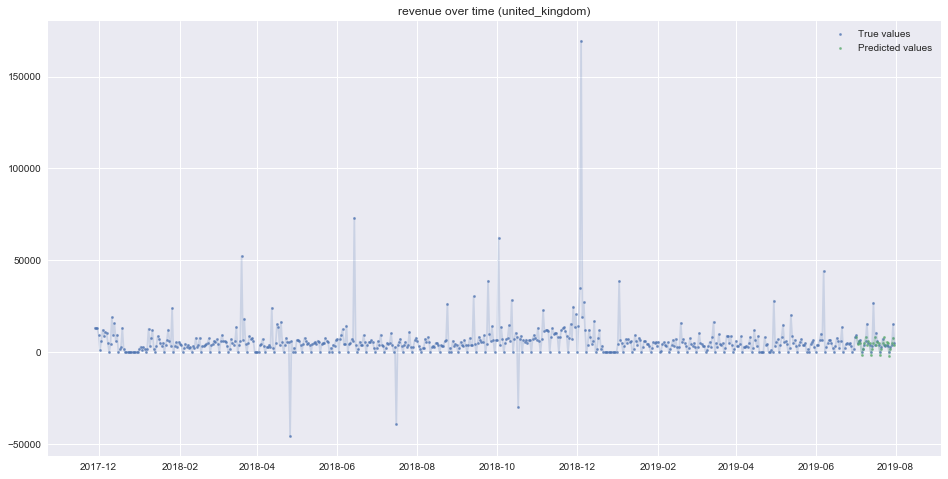

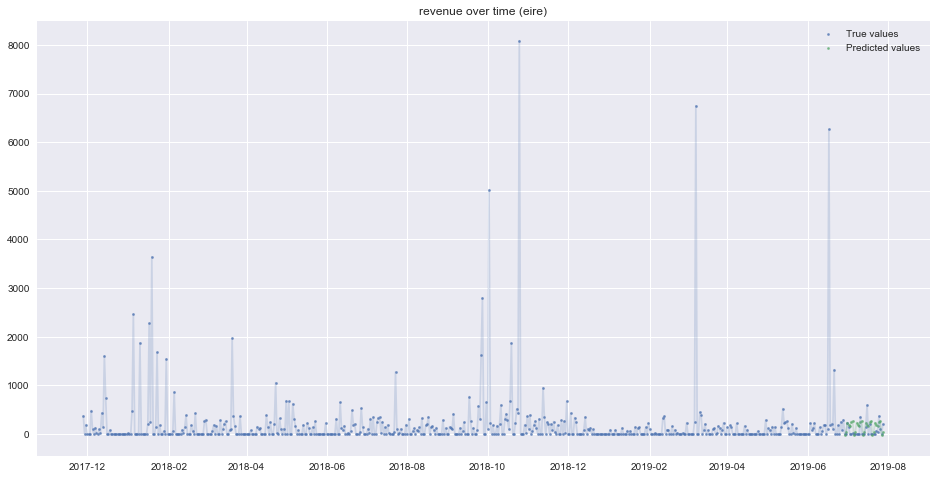

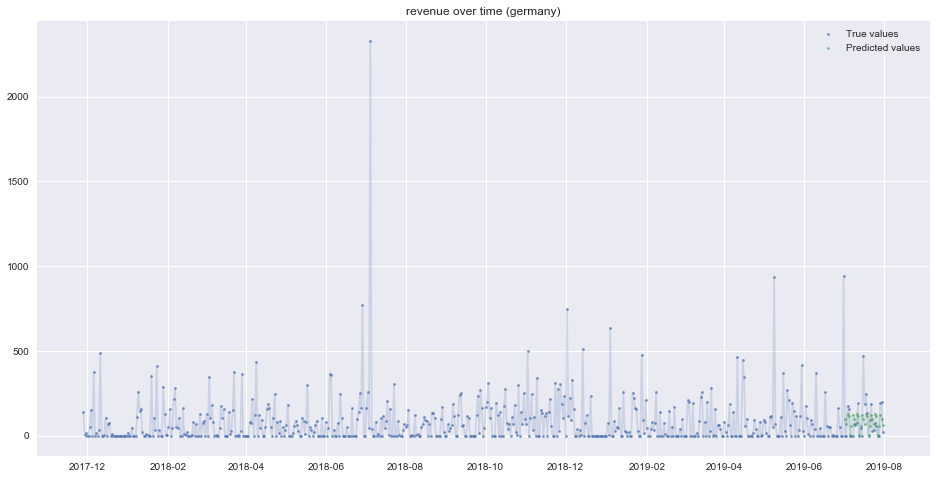

In [6]:
keys = ['all', 'united_kingdom', 'eire', 'germany']
y_pred = {}
mse_prophet = {}

for key in keys:
    df = ts_data[key][['date', 'revenue']].copy(deep=True)
    df.rename(columns={'date':'ds', 'revenue': 'y'},inplace=True)

    df_train = df[:-30]
    df_test = df[-30:]
    
    m = Prophet(weekly_seasonality=True)  
    m.fit(df_train)
    
    y_pred[key] = m.predict(df_test)
    
    mse_prophet[key] = mean_squared_error(df_test.y, y_pred[key].yhat)
    
    ts_plot_pred(df.ds.values, df.y.values,\
             df[-30:].ds.values, y_pred[key][-30:].yhat.values, figx=16,figy=8, title="revenue over time ({})".format(key))

In [7]:
for key in keys:
    if (mse_baseline[key] > mse_prophet[key]):
        print("{}: prophet performed better than baseline ({} vs {})".format(key,mse_prophet[key],mse_baseline[key]))
    else:
        print("{}: prophet performed worse than baseline ({} vs {})".format(key,mse_prophet[key],mse_baseline[key]))

print()
print("Average MSE for baseline: {}".format(np.mean([val for _,val in mse_baseline.items()])))
print("Average MSE for prophet: {}".format(np.mean([val for _,val in mse_prophet.items()])))

all: prophet performed better than baseline (25595969.460585415 vs 30037338.029319722)
united_kingdom: prophet performed better than baseline (26191175.56259271 vs 29388538.012207467)
eire: prophet performed better than baseline (27147.44711638386 vs 152295.0664701484)
germany: prophet performed better than baseline (8792.919264268467 vs 11290.637815593556)

Average MSE for baseline: 14897365.436453233
Average MSE for prophet: 12955771.347389696


We see that Prophet performs better than the baseline for the 4 time series observed, making it a good candidate for production.

## Supervised learning model (Random Forest)

As a last model, we try a supervised learning model, namely a Random Forest model, for forecasting. In order to use such models, some time series-related features must be engineered, such as revenue information over the last 7 days.

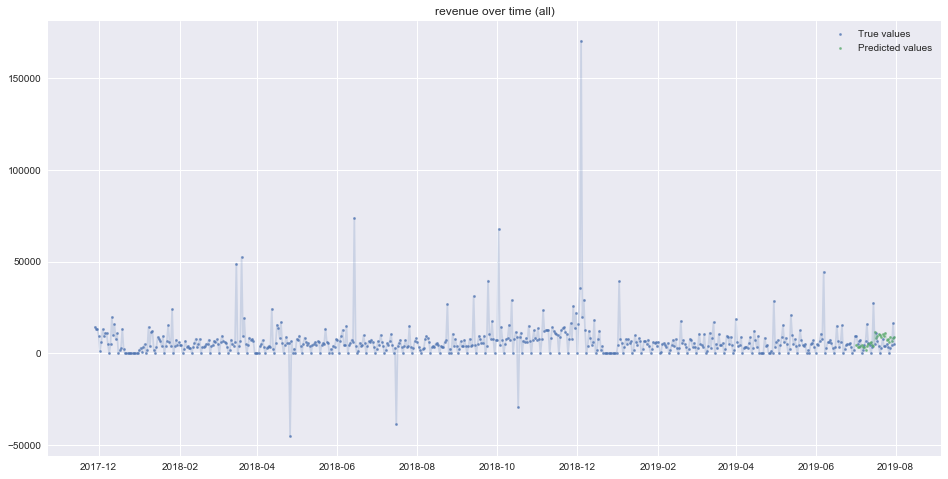

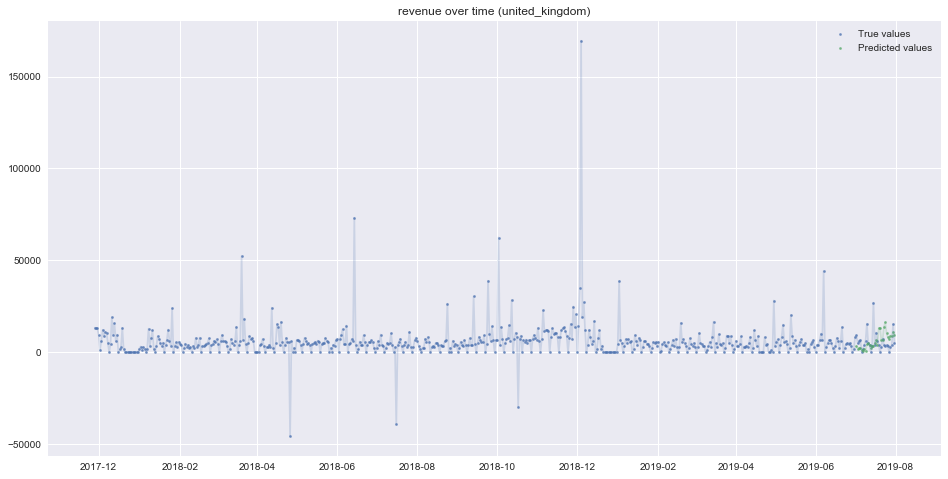

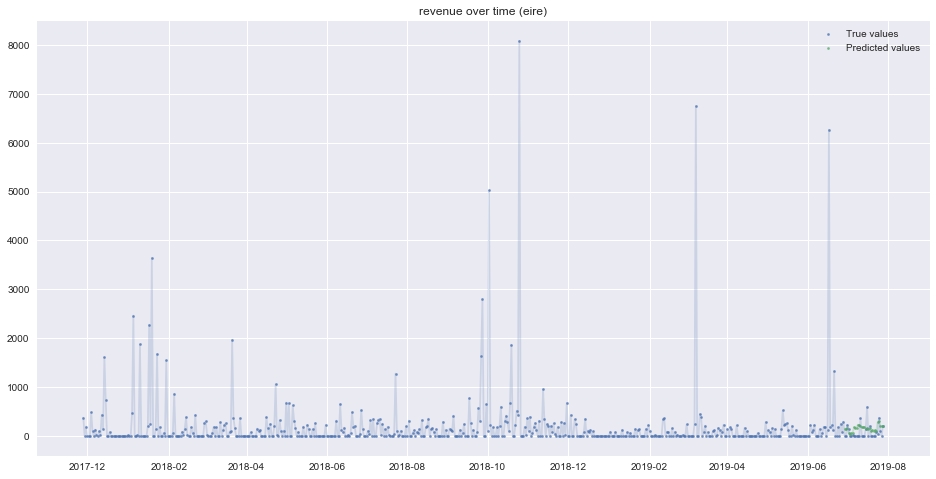

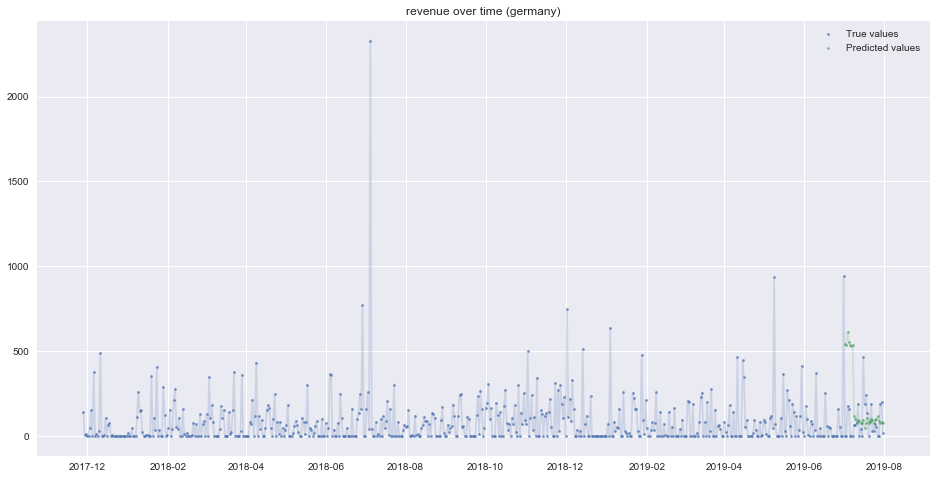

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

keys = ['all', 'united_kingdom', 'eire', 'germany']
y_pred = {}
mse_rf = {}

for key in keys:
    df = ts_data[key]
    X,y,dates = engineer_features(df)

    X_train = X[:-30].drop(columns=['day'])
    X_test = X[-30:].drop(columns=['day'])
    y_train = y[:-30]
    y_test = y[-30:]
    
    pipe_rf = Pipeline(steps=[('scaler', StandardScaler()),
                              ('rf', RandomForestRegressor())])
    pipe_rf.fit(X_train,y_train)
    
    y_pred[key] = pipe_rf.predict(X_test)
    
    mse_rf[key] = mean_squared_error(y_test, y_pred[key])
    
    ts_plot_pred(df.date.values, df.revenue.values,\
             df[-30:].date.values, y_pred[key], figx=16,figy=8, title="revenue over time ({})".format(key))

In [9]:
for key in keys:
    if (mse_prophet[key] > mse_rf[key]):
        print("{}: RF performed better than prophet ({} vs {})".format(key,mse_rf[key],mse_prophet[key]))
    else:
        print("{}: RF performed worse than prophet ({} vs {})".format(key,mse_rf[key],mse_prophet[key]))

print()
print("Average MSE for RF: {}".format(np.mean([val for _,val in mse_rf.items()])))
print("Average MSE for prophet: {}".format(np.mean([val for _,val in mse_prophet.items()])))

all: RF performed worse than prophet (44128706.266819686 vs 25595969.460585415)
united_kingdom: RF performed worse than prophet (52791279.74208187 vs 26191175.56259271)
eire: RF performed better than prophet (25557.62173767289 vs 27147.44711638386)
germany: RF performed worse than prophet (69318.0989686235 vs 8792.919264268467)

Average MSE for RF: 24253715.432401966
Average MSE for prophet: 12955771.347389696


We see that the RF model performs worse than Prophet, except for one case (EIRE) where it gets an only slightly better MSE.

## Comparison

We finish by comparing all MSEs obtained in a single plot. Below, you'll find the MSE comparison in normal scale and in log scale (due to the big difference in scale between the first two and the last two series). We can conclude that, among the models tested, Prophet shows the best performance, and should be chosen for production.

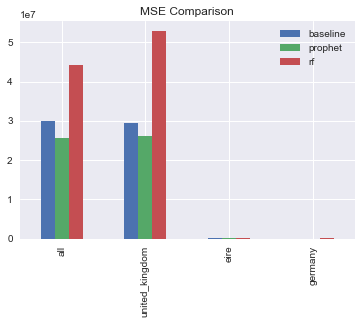

In [10]:
df_comparison = pd.DataFrame([mse_baseline,mse_prophet,mse_rf],index=['baseline','prophet','rf'])
_ = df_comparison.T.plot.bar(title="MSE Comparison")

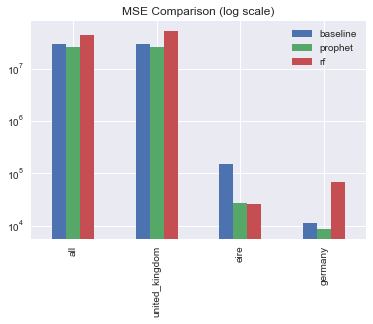

In [11]:
_ = df_comparison.T.plot.bar(logy=True,title="MSE Comparison (log scale)")